# Detección de Anomalías con Isolation Forest - Variables Categóricas

## Pseudocódigo Formal del Algoritmo Isolation Forest con Variables Mixtas

**ALGORITMO** `IsolationForest_Mixto(D_num, D_cat, n_trees, sub_sample_size)`

**ENTRADA:**
- `D_num ← {x₁ⁿᵘᵐ, x₂ⁿᵘᵐ, …, xₙⁿᵘᵐ}` (variables numéricas)
- `D_cat ← {x₁ᶜᵃᵗ, x₂ᶜᵃᵗ, …, xₘᶜᵃᵗ}` (variables categóricas)
- `n_trees` (número de árboles en el bosque)
- `sub_sample_size` (número de muestras por árbol)

**SALIDA:**
- `s(xᵢ)` → puntaje de anomalía para cada instancia `xᵢ ∈ D`

**PASOS:**

1. **Preprocesamiento de Variables Categóricas:**
   - `D_cat_encoded ← LabelEncoder(D_cat)`
   - `D_combined ← Concatenar(D_num, D_cat_encoded)`

2. **Construcción del Bosque de Aislamiento:**
   - **PARA** `t = 1` **HASTA** `n_trees` **HACER**
     - `S ← MuestraAleatoria(D_combined, sub_sample_size)`
     - `T_t ← iTree(S)` (construir árbol de aislamiento)

3. **Cálculo de Puntajes de Anomalía:**
   - **PARA cada instancia** `xᵢ ∈ D_combined` **HACER**
     - `h(xᵢ) ← promedio_profundidad(xᵢ, {T₁, T₂, ..., Tₙ})`
     - `s(xᵢ) ← 2^(-h(xᵢ)/c(n))` donde `c(n)` es factor de normalización

4. **RETORNAR** `s(xᵢ)` para cada `xᵢ ∈ D`

In [13]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, 
    recall_score, accuracy_score, classification_report,
    confusion_matrix
)
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de graficos
plt.style.use('ggplot')
sns.set_palette("husl")

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [14]:
# Carga de datos
ruta_datos = "../../data/data/application_train.csv"
datos = pd.read_csv(ruta_datos)

print(f"Datos cargados: {datos.shape}")
print(f"Tasa de fraude: {datos['TARGET'].mean()*100:.2f}%")
datos.head()

Datos cargados: (307511, 122)
Tasa de fraude: 8.07%


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# PREPARACION DE DATOS MIXTOS (NUMERICOS Y CATEGORICOS)

# Seleccionar variables importantes
variables_numericas = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
    'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'REGION_POPULATION_RELATIVE', 'HOUR_APPR_PROCESS_START'
]

variables_categoricas = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
]

# Filtrar variables que existen en el dataset
vars_num_disponibles = [col for col in variables_numericas if col in datos.columns]
vars_cat_disponibles = [col for col in variables_categoricas if col in datos.columns]

print(f"Variables numéricas disponibles: {len(vars_num_disponibles)}")
print(f"Variables categóricas disponibles: {len(vars_cat_disponibles)}")

Variables numéricas disponibles: 14
Variables categóricas disponibles: 10


In [16]:
# Extraer datos numericos y categoricos
datos_numericos = datos[vars_num_disponibles + ['TARGET']].copy()
datos_categoricos = datos[vars_cat_disponibles].copy()

print(f"Datos numéricos: {datos_numericos.shape}")
print(f"Datos categóricos: {datos_categoricos.shape}")

# Procesamiento de variables numericas
print("Procesando variables numéricas...")
for col in vars_num_disponibles:
    if datos_numericos[col].isnull().any():
        datos_numericos[col].fillna(datos_numericos[col].median(), inplace=True)

print(f"Valores nulos en variables numéricas: {datos_numericos.isnull().sum().sum()}")

Datos numéricos: (307511, 15)
Datos categóricos: (307511, 10)
Procesando variables numéricas...
Valores nulos en variables numéricas: 0


In [17]:
# Procesamiento de variables categoricas con Label Encoding
print("Procesando variables categóricas con Label Encoding...")

# Llenar valores nulos en categoricas
datos_categoricos = datos_categoricos.fillna('Desconocido')

# Aplicar Label Encoding
label_encoders = {}
datos_cat_encoded = datos_categoricos.copy()

for col in vars_cat_disponibles:
    le = LabelEncoder()
    datos_cat_encoded[col] = le.fit_transform(datos_categoricos[col])
    label_encoders[col] = le
    
print(f"Variables categóricas codificadas: {datos_cat_encoded.shape[1]}")
print("Ejemplo de codificación:")
for col in vars_cat_disponibles[:3]:
    print(f"{col}: {datos_categoricos[col].nunique()} categorías únicas")

Procesando variables categóricas con Label Encoding...
Variables categóricas codificadas: 10
Ejemplo de codificación:
NAME_CONTRACT_TYPE: 2 categorías únicas
CODE_GENDER: 3 categorías únicas
FLAG_OWN_CAR: 2 categorías únicas


In [18]:
# Combinar datos numericos y categoricos
datos_combinados = pd.concat([
    datos_numericos.drop('TARGET', axis=1), 
    datos_cat_encoded
], axis=1)

print(f"Dataset combinado: {datos_combinados.shape}")
print(f"Total de features: {datos_combinados.shape[1]}")

# Preparar muestra para entrenamiento
muestra_size = 15000
muestra_indices = np.random.choice(len(datos_combinados), muestra_size, replace=False)

X_muestra = datos_combinados.iloc[muestra_indices]
y_muestra = datos_numericos.iloc[muestra_indices]['TARGET']

print(f"Muestra para entrenamiento: {X_muestra.shape}")
print(f"Distribución de la muestra - Fraude: {y_muestra.mean()*100:.2f}%")

Dataset combinado: (307511, 24)
Total de features: 24
Muestra para entrenamiento: (15000, 24)
Distribución de la muestra - Fraude: 7.89%


In [19]:
# Normalizar las variables para mejorar el rendimiento
print("Aplicando normalización...")
scaler = StandardScaler()
X_muestra_scaled = scaler.fit_transform(X_muestra)

print("Normalización completada")

Aplicando normalización...
Normalización completada


In [20]:
# IMPLEMENTACION DEL ISOLATION FOREST CON VARIABLES MIXTAS

print("Entrenando Isolation Forest con variables mixtas...")

# Configuración del modelo
isolation_forest = IsolationForest(
    n_estimators=200,           # Número de árboles
    max_samples=0.8,           # Fracción de muestras por árbol
    contamination=0.1,         # Proporción esperada de anomalías
    random_state=42,
    n_jobs=-1                  # Usar todos los cores disponibles
)

# Entrenar el modelo
isolation_forest.fit(X_muestra_scaled)

print("Entrenamiento completado")

Entrenando Isolation Forest con variables mixtas...
Entrenamiento completado


In [21]:
# Obtener predicciones
y_pred_anomalia = isolation_forest.predict(X_muestra_scaled)
puntuaciones_anomalia = isolation_forest.decision_function(X_muestra_scaled)

# Convertir predicciones: -1 (anomalía) -> 1 (fraude), 1 (normal) -> 0 (no fraude)
y_pred_fraude = np.where(y_pred_anomalia == -1, 1, 0)

print(f"Anomalías detectadas: {sum(y_pred_fraude)} de {len(y_pred_fraude)}")
print(f"Porcentaje de anomalías: {sum(y_pred_fraude)/len(y_pred_fraude)*100:.2f}%")

Anomalías detectadas: 1500 de 15000
Porcentaje de anomalías: 10.00%


In [22]:
# Como no tenemos etiquetas verdaderas, usamos métricas de clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Para tener una referencia, creamos etiquetas sintéticas usando clustering
# Esto nos permitirá evaluar la calidad de la detección de anomalías
kmeans = KMeans(n_clusters=2, random_state=42)
y_synthetic = kmeans.fit_predict(X_muestra_scaled)

# Métricas de evaluación
silhouette_avg = silhouette_score(X_muestra_scaled, y_pred_fraude)
proporcion_anomalias = sum(y_pred_fraude) / len(y_pred_fraude)

print("MÉTRICAS DE EVALUACIÓN:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Proporción de anomalías detectadas: {proporcion_anomalias:.4f}")
print(f"Número total de muestras analizadas: {len(y_pred_fraude)}")
print(f"Número de anomalías encontradas: {sum(y_pred_fraude)}")

# Distribución de puntuaciones
print(f"\nDISTRIBUCIÓN DE PUNTUACIONES:")
print(f"Puntuación mínima: {min(puntuaciones_anomalia):.4f}")
print(f"Puntuación máxima: {max(puntuaciones_anomalia):.4f}")
print(f"Puntuación promedio: {np.mean(puntuaciones_anomalia):.4f}")
print(f"Desviación estándar: {np.std(puntuaciones_anomalia):.4f}")

MÉTRICAS DE EVALUACIÓN:
Silhouette Score: 0.1678
Proporción de anomalías detectadas: 0.1000
Número total de muestras analizadas: 15000
Número de anomalías encontradas: 1500

DISTRIBUCIÓN DE PUNTUACIONES:
Puntuación mínima: -0.1585
Puntuación máxima: 0.1140
Puntuación promedio: 0.0450
Desviación estándar: 0.0327


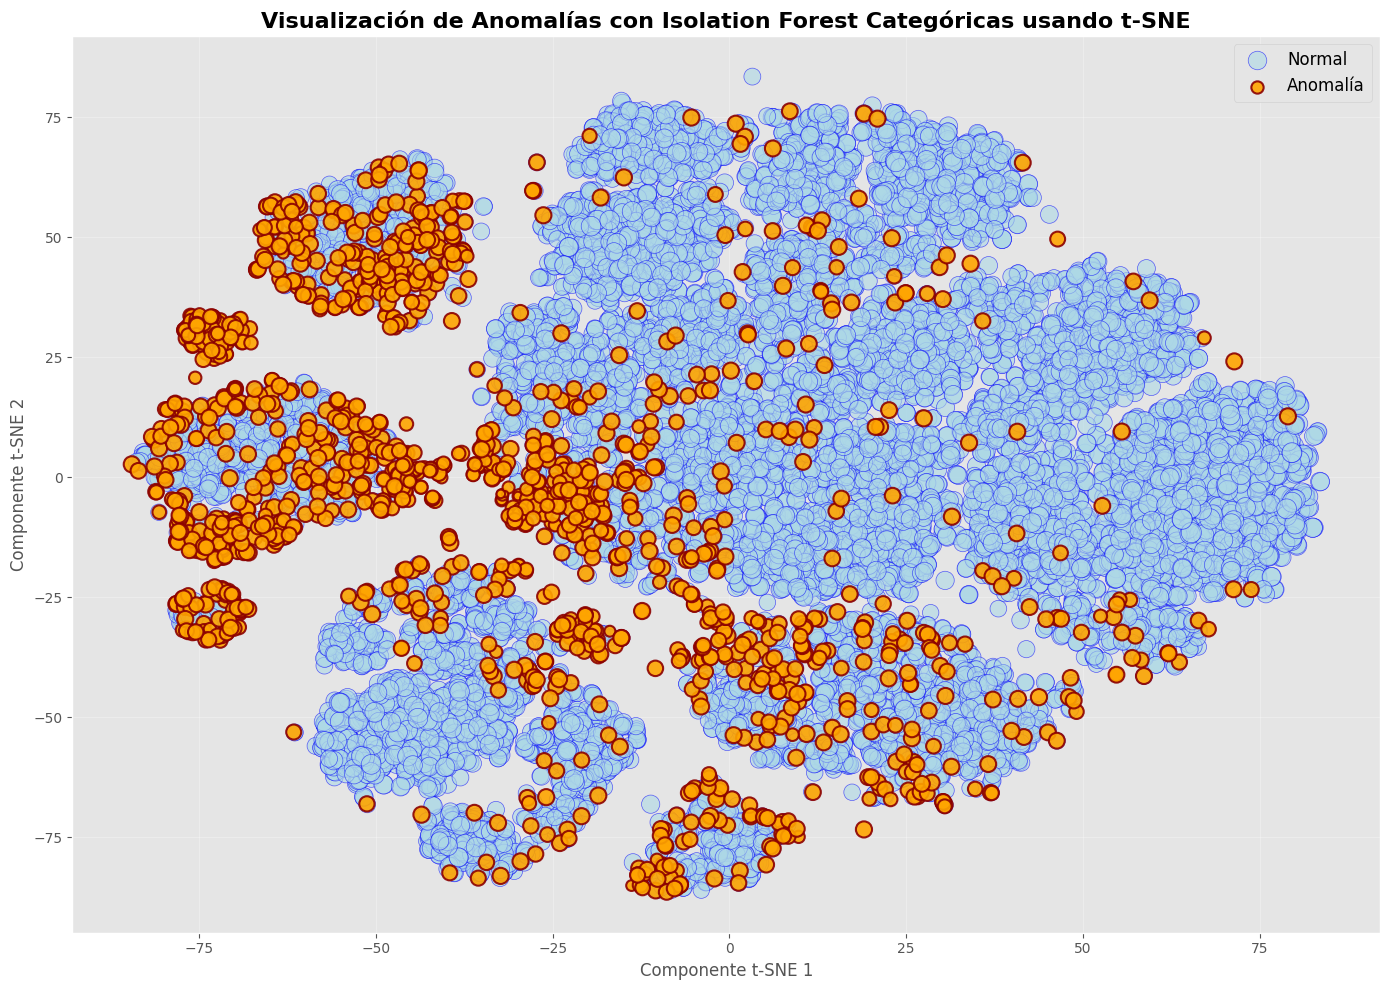

Visualización t-SNE generada exitosamente.


In [23]:
# Visualización con t-SNE (consistente con IsolationForest.ipynb)
from sklearn.manifold import TSNE

# Aplicar t-SNE para reducción dimensional
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reducido = tsne.fit_transform(X_muestra_scaled)

# Crear la visualización
plt.figure(figsize=(14, 10))

# Separar datos normales y anomalías
normales = y_pred_anomalia == 1
anomalias = y_pred_anomalia == -1

# Normalizar scores para el tamaño de los círculos
scores_norm = (puntuaciones_anomalia - puntuaciones_anomalia.min()) / (puntuaciones_anomalia.max() - puntuaciones_anomalia.min())
tamaños = 20 + scores_norm * 200

# Graficar puntos normales (azul para Isolation Forest)
plt.scatter(X_reducido[normales, 0], X_reducido[normales, 1],
           c='lightblue', s=tamaños[normales], alpha=0.6,
           edgecolors='blue', linewidth=0.5, label='Normal')

# Graficar anomalías (naranja para Isolation Forest)
plt.scatter(X_reducido[anomalias, 0], X_reducido[anomalias, 1],
           c='orange', s=tamaños[anomalias], alpha=0.9,
           edgecolors='darkred', linewidth=1.5, label='Anomalía', marker='o')

plt.title('Visualización de Anomalías con Isolation Forest Categóricas usando t-SNE', fontsize=16, fontweight='bold')
plt.xlabel('Componente t-SNE 1', fontsize=12)
plt.ylabel('Componente t-SNE 2', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualización t-SNE generada exitosamente.")

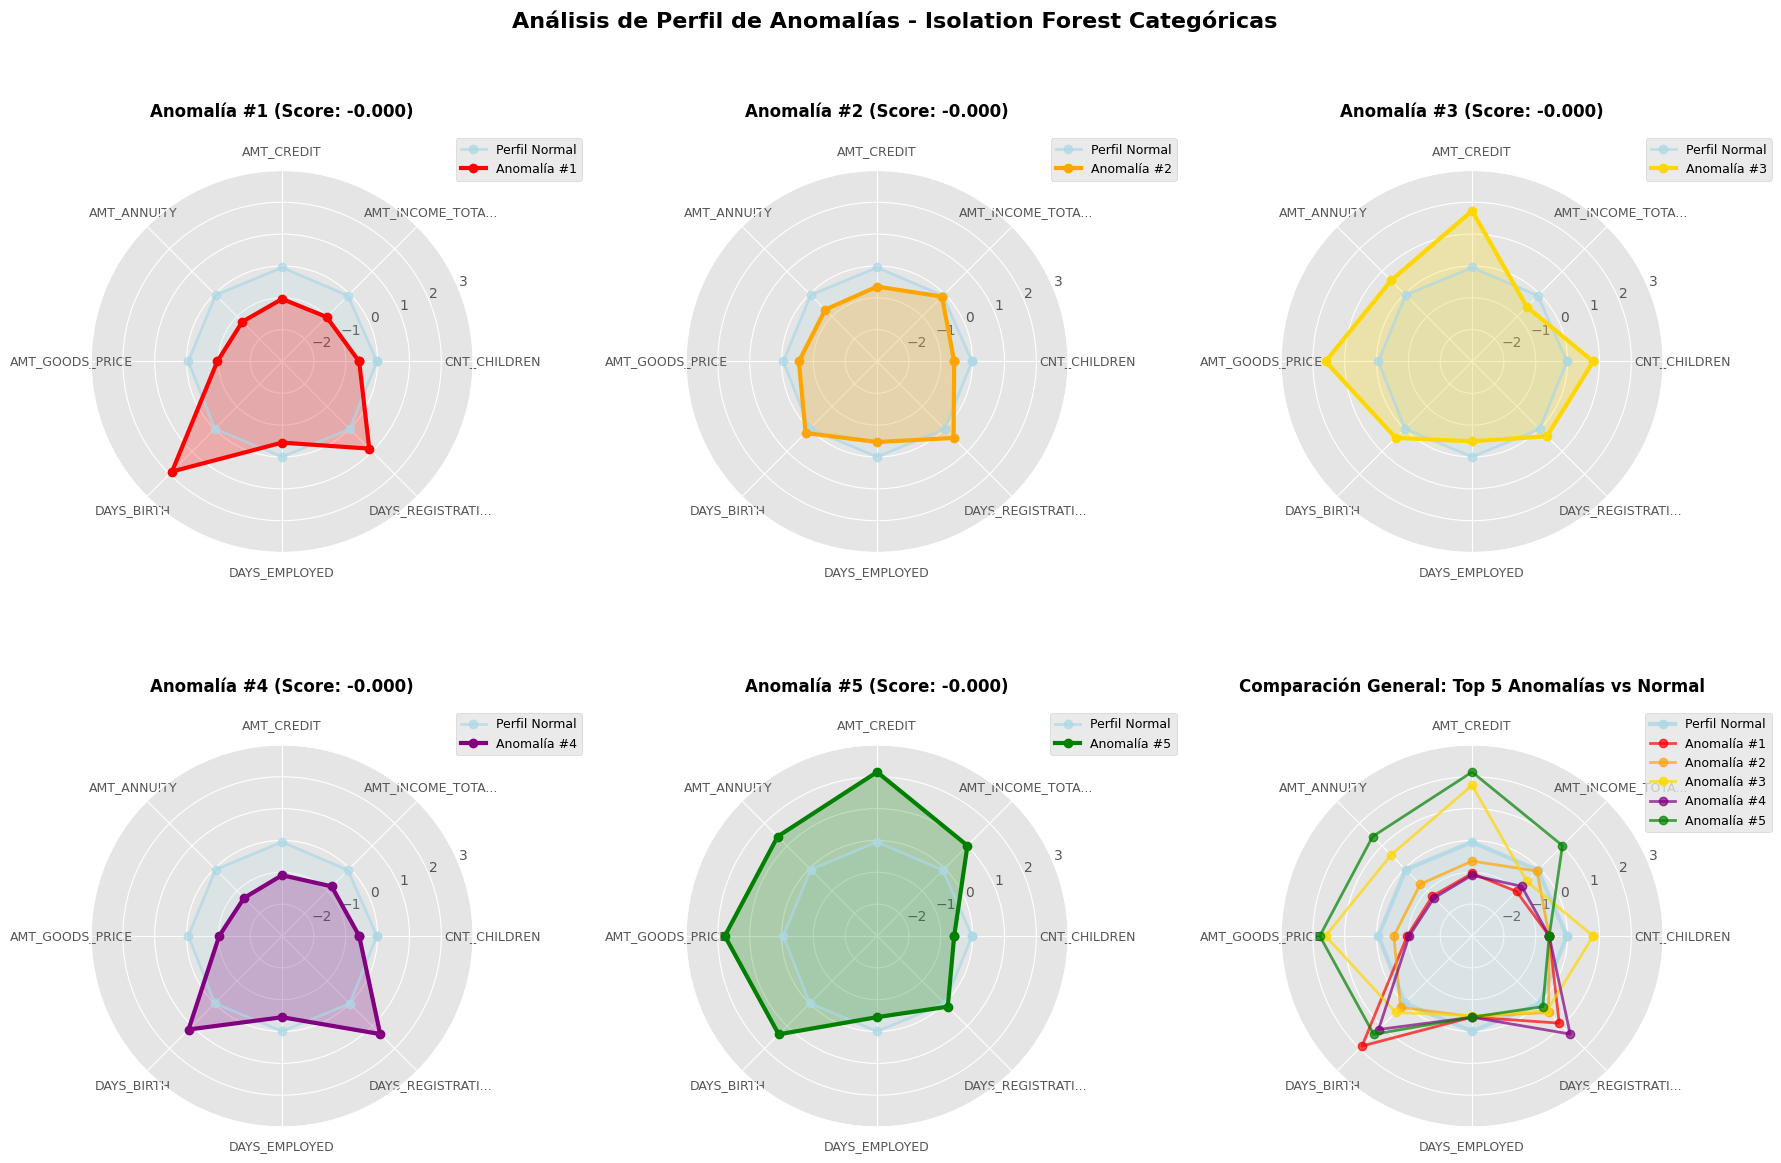

Gráficos de radar generados exitosamente.


In [24]:
# Gráfico de Radar para entender el contexto de las anomalías (consistente con IsolationForest.ipynb)
from sklearn.preprocessing import StandardScaler

# Crear DataFrame con los datos para análisis de radar
D_radar = pd.DataFrame(X_muestra_scaled, columns=X_muestra.columns)
D_radar['score_anomalia'] = puntuaciones_anomalia
D_radar['es_anomalia'] = np.where(y_pred_anomalia == -1, 'Anomalía', 'Normal')

# Seleccionar variables clave para el radar (primeras 8 variables)
vars_radar = list(X_muestra.columns)[:8]

# Obtener top 5 anomalías
top_anomalias = D_radar[D_radar['es_anomalia'] == 'Anomalía'].nlargest(5, 'score_anomalia')

# Calcular perfil promedio de casos normales
perfil_normal = D_radar[D_radar['es_anomalia'] == 'Normal'][vars_radar].mean()

# Configuración del gráfico polar
colores = ['red', 'orange', 'gold', 'purple', 'green']
N = len(vars_radar)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

categorias = [var[:15] + '...' if len(var) > 15 else var for var in vars_radar]

# Crear subplots polares (2x3)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Normalizar datos para mejor visualización
scaler_radar = StandardScaler()
data_for_scaling = D_radar[vars_radar]
scaler_radar.fit(data_for_scaling)

# Gráfico individual para cada anomalía
for idx, (_, anomalia) in enumerate(top_anomalias.iterrows()):
    ax = axes[idx]
    
    # Obtener valores normalizados de la anomalía
    valores_anomalia = D_radar.loc[anomalia.name, vars_radar].values.tolist()
    valores_anomalia += valores_anomalia[:1]
    
    valores_normal = perfil_normal.values.tolist()
    valores_normal += valores_normal[:1]
    
    # Graficar perfil normal
    ax.plot(angles, valores_normal, 'o-', linewidth=2, label='Perfil Normal', color='lightblue', alpha=0.7)
    ax.fill(angles, valores_normal, alpha=0.15, color='lightblue')
    
    # Graficar anomalía
    color = colores[idx]
    ax.plot(angles, valores_anomalia, 'o-', linewidth=3, label=f'Anomalía #{idx+1}', color=color)
    ax.fill(angles, valores_anomalia, alpha=0.25, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categorias, size=9)
    ax.set_ylim(-3, 3)
    ax.set_title(f'Anomalía #{idx+1} (Score: {anomalia["score_anomalia"]:.3f})', 
                 size=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.grid(True)

# Gráfico comparativo general (subplot 6)
ax = axes[5]
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

valores_normal = perfil_normal.values.tolist()
valores_normal += valores_normal[:1]

ax.plot(angles, valores_normal, 'o-', linewidth=3, label='Perfil Normal', color='lightblue', alpha=0.8)
ax.fill(angles, valores_normal, alpha=0.2, color='lightblue')

for idx, (_, anomalia) in enumerate(top_anomalias.iterrows()):
    valores_anomalia = D_radar.loc[anomalia.name, vars_radar].values.tolist()
    valores_anomalia += valores_anomalia[:1]
    ax.plot(angles, valores_anomalia, 'o-', linewidth=2, label=f'Anomalía #{idx+1}', 
            color=colores[idx], alpha=0.7)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categorias, size=9)
ax.set_ylim(-3, 3)
ax.set_title('Comparación General: Top 5 Anomalías vs Normal', 
             size=12, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax.grid(True)

plt.suptitle('Análisis de Perfil de Anomalías - Isolation Forest Categóricas', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Gráficos de radar generados exitosamente.")

In [27]:
# Calcular métricas de evaluación
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Obtener etiquetas reales y normalizar scores
target_real = y_muestra.values
scores_norm = (puntuaciones_anomalia - puntuaciones_anomalia.min()) / (puntuaciones_anomalia.max() - puntuaciones_anomalia.min())

# Calcular métricas
roc_auc = roc_auc_score(target_real, scores_norm)
precision = precision_score(target_real, y_pred_fraude, zero_division=0)
recall = recall_score(target_real, y_pred_fraude, zero_division=0)
f1 = f1_score(target_real, y_pred_fraude, zero_division=0)

# METRICAS FINALES - ISOLATION FOREST CATEGORICAS
tabla_metricas = pd.DataFrame({
    'Modelo': ['IsolationForest_Categoricas'],
    'Features': [X_muestra.shape[1]],
    'ROC-AUC': [roc_auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
})

print("Metricas Finales - Isolation Forest Categoricas:")
print("=" * 70)
print(tabla_metricas.round(6).to_string(index=False))

# Guardar métricas
import os
os.makedirs('../../data/processed', exist_ok=True)
tabla_metricas.to_csv('../../data/processed/metricas_isolation_forest_categoricas.csv', index=False)

Metricas Finales - Isolation Forest Categoricas:
                     Modelo  Features  ROC-AUC  Precision   Recall  F1-Score
IsolationForest_Categoricas        24 0.510017   0.067333 0.085376  0.075289
